In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Apr  5 10:44:06 2020

@author: triet
"""
import os
import pandas as pd
import numpy as np
import wget
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [3]:
#refresh data from github of university Johns Hopkins
"""
base_data_path = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
data_files = ["time_series_covid19_confirmed_global.csv", "time_series_covid19_deaths_global.csv", "time_series_covid19_recovered_global.csv"]

for file in data_files:
    if os.path.exists(file):
        os.remove(file)
    wget.download(os.path.join(base_data_path, file))
"""

'\nbase_data_path = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"\ndata_files = ["time_series_covid19_confirmed_global.csv", "time_series_covid19_deaths_global.csv", "time_series_covid19_recovered_global.csv"]\n\nfor file in data_files:\n    if os.path.exists(file):\n        os.remove(file)\n    wget.download(os.path.join(base_data_path, file))\n'

In [2]:
#get data of US
data_confirmed = np.asarray(pd.read_csv("./data/time_series_covid19_confirmed_global.csv").to_numpy()[225,4:], dtype=np.uint32).reshape(-1,1)
data_deaths = np.asarray(pd.read_csv("./data/time_series_covid19_deaths_global.csv").to_numpy()[225,4:], dtype=np.uint32).reshape(-1,1)
data_recovered = np.asarray(pd.read_csv("./data/time_series_covid19_recovered_global.csv").to_numpy()[225,4:], dtype=np.uint32).reshape(-1,1)

In [3]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [4]:
#percent split train test data
percent_split = 0.85

#get data
data_train_C = data_confirmed[:int(percent_split*len(data_confirmed))]
data_test_C = data_confirmed[int(percent_split*len(data_confirmed)):]

data_train_D = data_deaths[:int(percent_split*len(data_deaths))]
data_test_D = data_deaths[int(percent_split*len(data_deaths)):]

data_train_R = data_recovered[:int(percent_split*len(data_recovered))]
data_test_R = data_recovered[int(percent_split*len(data_recovered)):]

In [5]:
#Choose timesteps, features and number of days in future
n_steps = 1
n_features = 1
days_future = 10

In [6]:
# split into samples
X_train_C, y_train_C = split_sequence(data_train_C, n_steps)
X_test_C, y_test_C = split_sequence(data_test_C, n_steps)
X_C, y_C = split_sequence(data_confirmed, n_steps)

X_train_D, y_train_D = split_sequence(data_train_D, n_steps)
X_test_D, y_test_D = split_sequence(data_test_D, n_steps)
X_D, y_D = split_sequence(data_deaths, n_steps)

X_train_R, y_train_R = split_sequence(data_train_R, n_steps)
X_test_R, y_test_R = split_sequence(data_test_R, n_steps)
X_R, y_R = split_sequence(data_recovered, n_steps)

In [7]:
def predict_include_future(model, data, nb_days, n_steps):
    y_preds = model.predict(data)
    for i in range(nb_days):
        seq = y_preds[-n_steps:].reshape(1,n_steps,n_features)
        pred_day = model.predict(seq)
        y_preds = np.concatenate((y_preds, pred_day))
    return y_preds

In [8]:
#build model
def build_model(nb_node):  
    model = Sequential()
    model.add(LSTM(nb_node, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.summary()
    return model

## Model and prediction for Confirmed cases

In [9]:
nb_node = 50
model_C = build_model(nb_node)
#compile model
model_C.compile(optimizer='adam', loss='mse')

# fit model
model_C.fit(X_train_C, y_train_C, epochs=200, verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [10]:
y_test_pred_C = model_C.predict(X_test_C)

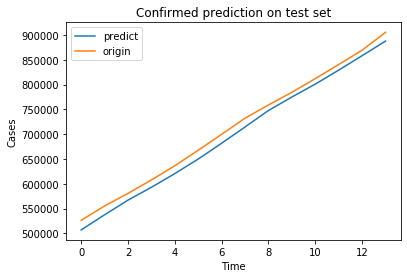

In [11]:
plt.plot(y_test_pred_C.reshape(-1,1), label='predict')
plt.plot(y_test_C, label='origin')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cases')
plt.title('Confirmed prediction on test set')
plt.show()

In [12]:
y_pred_C = predict_include_future(model_C, X_C, days_future, n_steps)

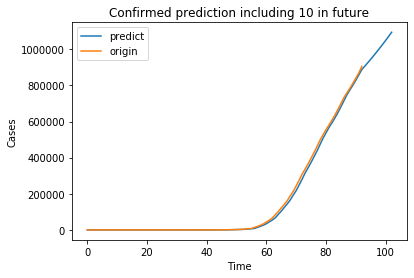

In [14]:
plt.plot(y_pred_C.reshape(-1,1), label='predict')
plt.plot(data_confirmed[n_steps:], label='origin')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cases')
plt.title('Confirmed prediction including '+str(days_future)+' in future')
plt.show()

## Model and prediction for Deaths cases

In [15]:
nb_node = 50
model_D = build_model(nb_node)
#compile model
model_D.compile(optimizer='adam', loss='mse')

# fit model
model_D.fit(X_train_D, y_train_D, epochs=200, verbose=0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [16]:
y_test_pred_D = model_D.predict(X_test_D)

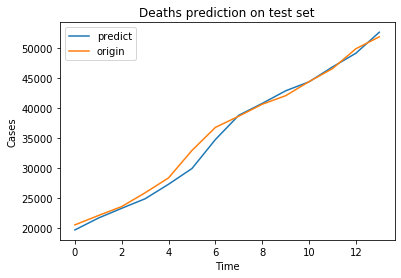

In [17]:
plt.plot(y_test_pred_D.reshape(-1,1), label='predict')
plt.plot(y_test_D, label='origin')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cases')
plt.title('Deaths prediction on test set')
plt.show()

In [18]:
y_pred_D = predict_include_future(model_D, X_D, days_future, n_steps)

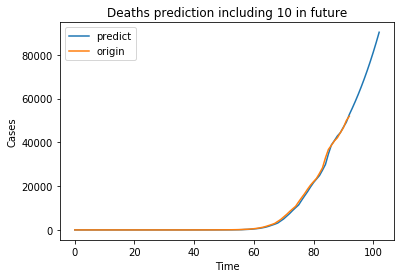

In [20]:
plt.plot(y_pred_D.reshape(-1,1), label='predict')
plt.plot(data_deaths[n_steps:], label='origin')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cases')
plt.title('Deaths prediction including '+str(days_future)+' in future')
plt.show()

## Model and prediction for Recovered cases

In [21]:
nb_node = 100
model_R = build_model(nb_node)
#compile model
model_R.compile(optimizer='adam', loss='mse')

# fit model
model_R.fit(X_train_R, y_train_R, epochs=200, verbose=0)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
y_test_pred_R = model_R.predict(X_test_R)

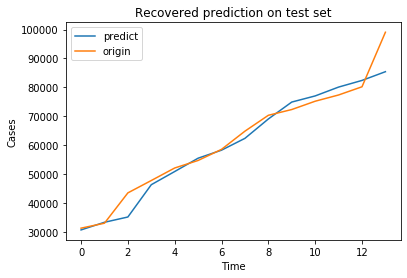

In [23]:
plt.plot(y_test_pred_R.reshape(-1,1), label='predict')
plt.plot(y_test_R, label='origin')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cases')
plt.title('Recovered prediction on test set')
plt.show()

In [24]:
y_pred_R = predict_include_future(model_R, X_R, days_future, n_steps)

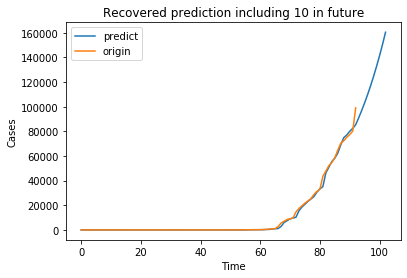

In [26]:
plt.plot(y_pred_R.reshape(-1,1), label='predict')
plt.plot(data_recovered[n_steps:], label='origin')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cases')
plt.title('Recovered prediction including '+str(days_future)+' in future')
plt.show()